## ライブラリのインポート

In [1]:
import numpy as np
# ボストンの住宅情報
from sklearn.datasets import load_boston
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

# テスト用データの読み込み

In [32]:
class BostonDataset(Dataset):
    def __init__(self, testsize=0.2):
        boston = load_boston()
        X=boston.data
        Y=boston.target
        
        # 訓練データと検証データに分割する
        X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=testsize, random_state=1) 
        
        # テンソルに変換
        self.X_data = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.Y_data = torch.FloatTensor(Y_train)
        self.Y_test = torch.FloatTensor(Y_test)
        
        self.datalen = len(self.Y_data)
        self.in_size = self.X_data.shape[1]
        self.out_size = 1
        print('X_size', self.in_size)
        print('Y_size', self.out_size)
        
        
    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]
    
    def __len__(self):
        return self.datalen

In [33]:
Batch_size = 128
dataset = BostonDataset()
trainloader = DataLoader(dataset=dataset, batch_size = Batch_size, shuffle=True)

X_size 13
Y_size 1


# ニューラルネットワークの定義

ニューラルネットワークのノード数や階層を定義する \
出力値を求める関数を定義する（ノード数によって変わる、求めたい値によっても変わる）

In [35]:
# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net(nn.Module):
    # 初期化の関数
    def __init__(self, in_features, out_features, h1=32, h2=24, h3=24):
        super(Net ,self).__init__()
        #   中間層のノード数は、精度向上やパフォーマンス向上を狙って調整する
        self.fc1 = nn.Linear(in_features , h1)
        self.fc2 = nn.Linear(h1, h2)         
        self.fc3 = nn.Linear(h2, h3)         
        self.fc4 = nn.Linear(h3,  out_features) 
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
        
        x = F.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = F.relu(self.fc2(x))              # 中間層（１階層目）の結果を中間層（２階層目）に渡して結果を得る
        x = F.relu(self.fc3(x))              # 中間層（２階層目）の結果を中間層（３階層目）に渡して結果を得る
        x = self.fc4(x)                      # 中間層（３階層目）の結果を出力層に渡す
        return x  

# 学習する

In [46]:
# モデルの定義
model = Net(in_features = dataset.in_size, out_features = dataset.out_size )
# 損失の定義 (平均二乗誤差)
criterion = nn.MSELoss()

In [47]:
# 最適化のアルゴリズムの選択　（Adam：adaptive moment estimation）
## model.parameters  調整する値
## lr(learning rate) ：学習率　どれぐらいの幅でパラメータを更新していくのか
optimizer = optim.Adam(model.parameters() , lr=0.01)

In [48]:
epochs=150
loss_list = []
loss_temp = 0

logdisp=10

acccnt=len(dataset)*logdisp


# 損失を初期化　
total_loss = 0

# トレーニングの回数分ループする。
for epoch in range(epochs):

    
    # データの件数分ループする。（x_train , y_train　に１レコードずつ格納される）
    for x_train , y_train in trainloader:
        # Variable ：　torch,autograd.Variable  ：テンソルをwrapして計算操作を記録する
        x_train ,y_train = Variable(x_train) ,Variable(y_train)
        # 出力を計算する 
        output = model(x_train)
        # 損失の計算 (出力の結果；output と 正解：train_yを渡す)
        loss = criterion(output ,y_train)
        # パラメータの勾配を初期化する
        optimizer.zero_grad()
        # ロスを伝播する
        loss.backward()
        # パラメータを更新する
        optimizer.step()
        # トータルロスを格納
        total_loss += loss.item()
    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp=total_loss/acccnt
        print(f'Epoch\t{epoch+1}\t\tLoss\t{loss_tmp:.8f}')
        
        loss_list.append(loss_tmp)
        loss_temp=0
        total_loss=0
    

Epoch	10		Loss	1.22940613
Epoch	20		Loss	0.82577902
Epoch	30		Loss	0.86182780
Epoch	40		Loss	0.86927577
Epoch	50		Loss	0.83531874
Epoch	60		Loss	0.84437306
Epoch	70		Loss	0.81130255
Epoch	80		Loss	0.88172152
Epoch	90		Loss	0.85904779
Epoch	100		Loss	0.82578599
Epoch	110		Loss	0.85596240
Epoch	120		Loss	0.80737096
Epoch	130		Loss	0.82328103
Epoch	140		Loss	0.84448607
Epoch	150		Loss	0.85160959


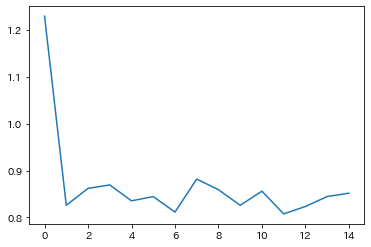

In [49]:
# ロスのプロット
plt.plot(loss_list)

## 誤差の確認

In [52]:
# 学習を行わないモードに変更
model.eval()

# テストデータ
x_test ,y_test = Variable(dataset.X_test) ,Variable(dataset.Y_test)
# テストデータｘに対する結果　（値の大きい方を取得する）
y_hat = model(x_test).data

err = y_hat - y_test
err

tensor([[-6.7125, -2.4125,  4.8875,  ..., -0.2125, 11.2875,  6.0875],
        [-5.7602, -1.4602,  5.8398,  ...,  0.7398, 12.2398,  7.0398],
        [-6.3009, -2.0009,  5.2991,  ...,  0.1991, 11.6991,  6.4991],
        ...,
        [-6.1908, -1.8908,  5.4092,  ...,  0.3092, 11.8092,  6.6092],
        [-7.9976, -3.6976,  3.6024,  ..., -1.4976, 10.0024,  4.8024],
        [-6.7698, -2.4698,  4.8302,  ..., -0.2698, 11.2302,  6.0302]])

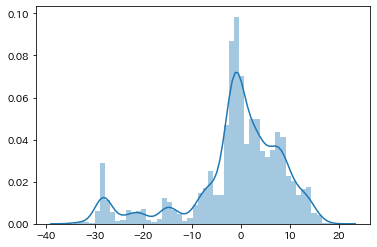

In [53]:
%matplotlib inline
import seaborn as sns

# 分布の確認
sns.distplot(err)

## 検証データを使って予測値の検証

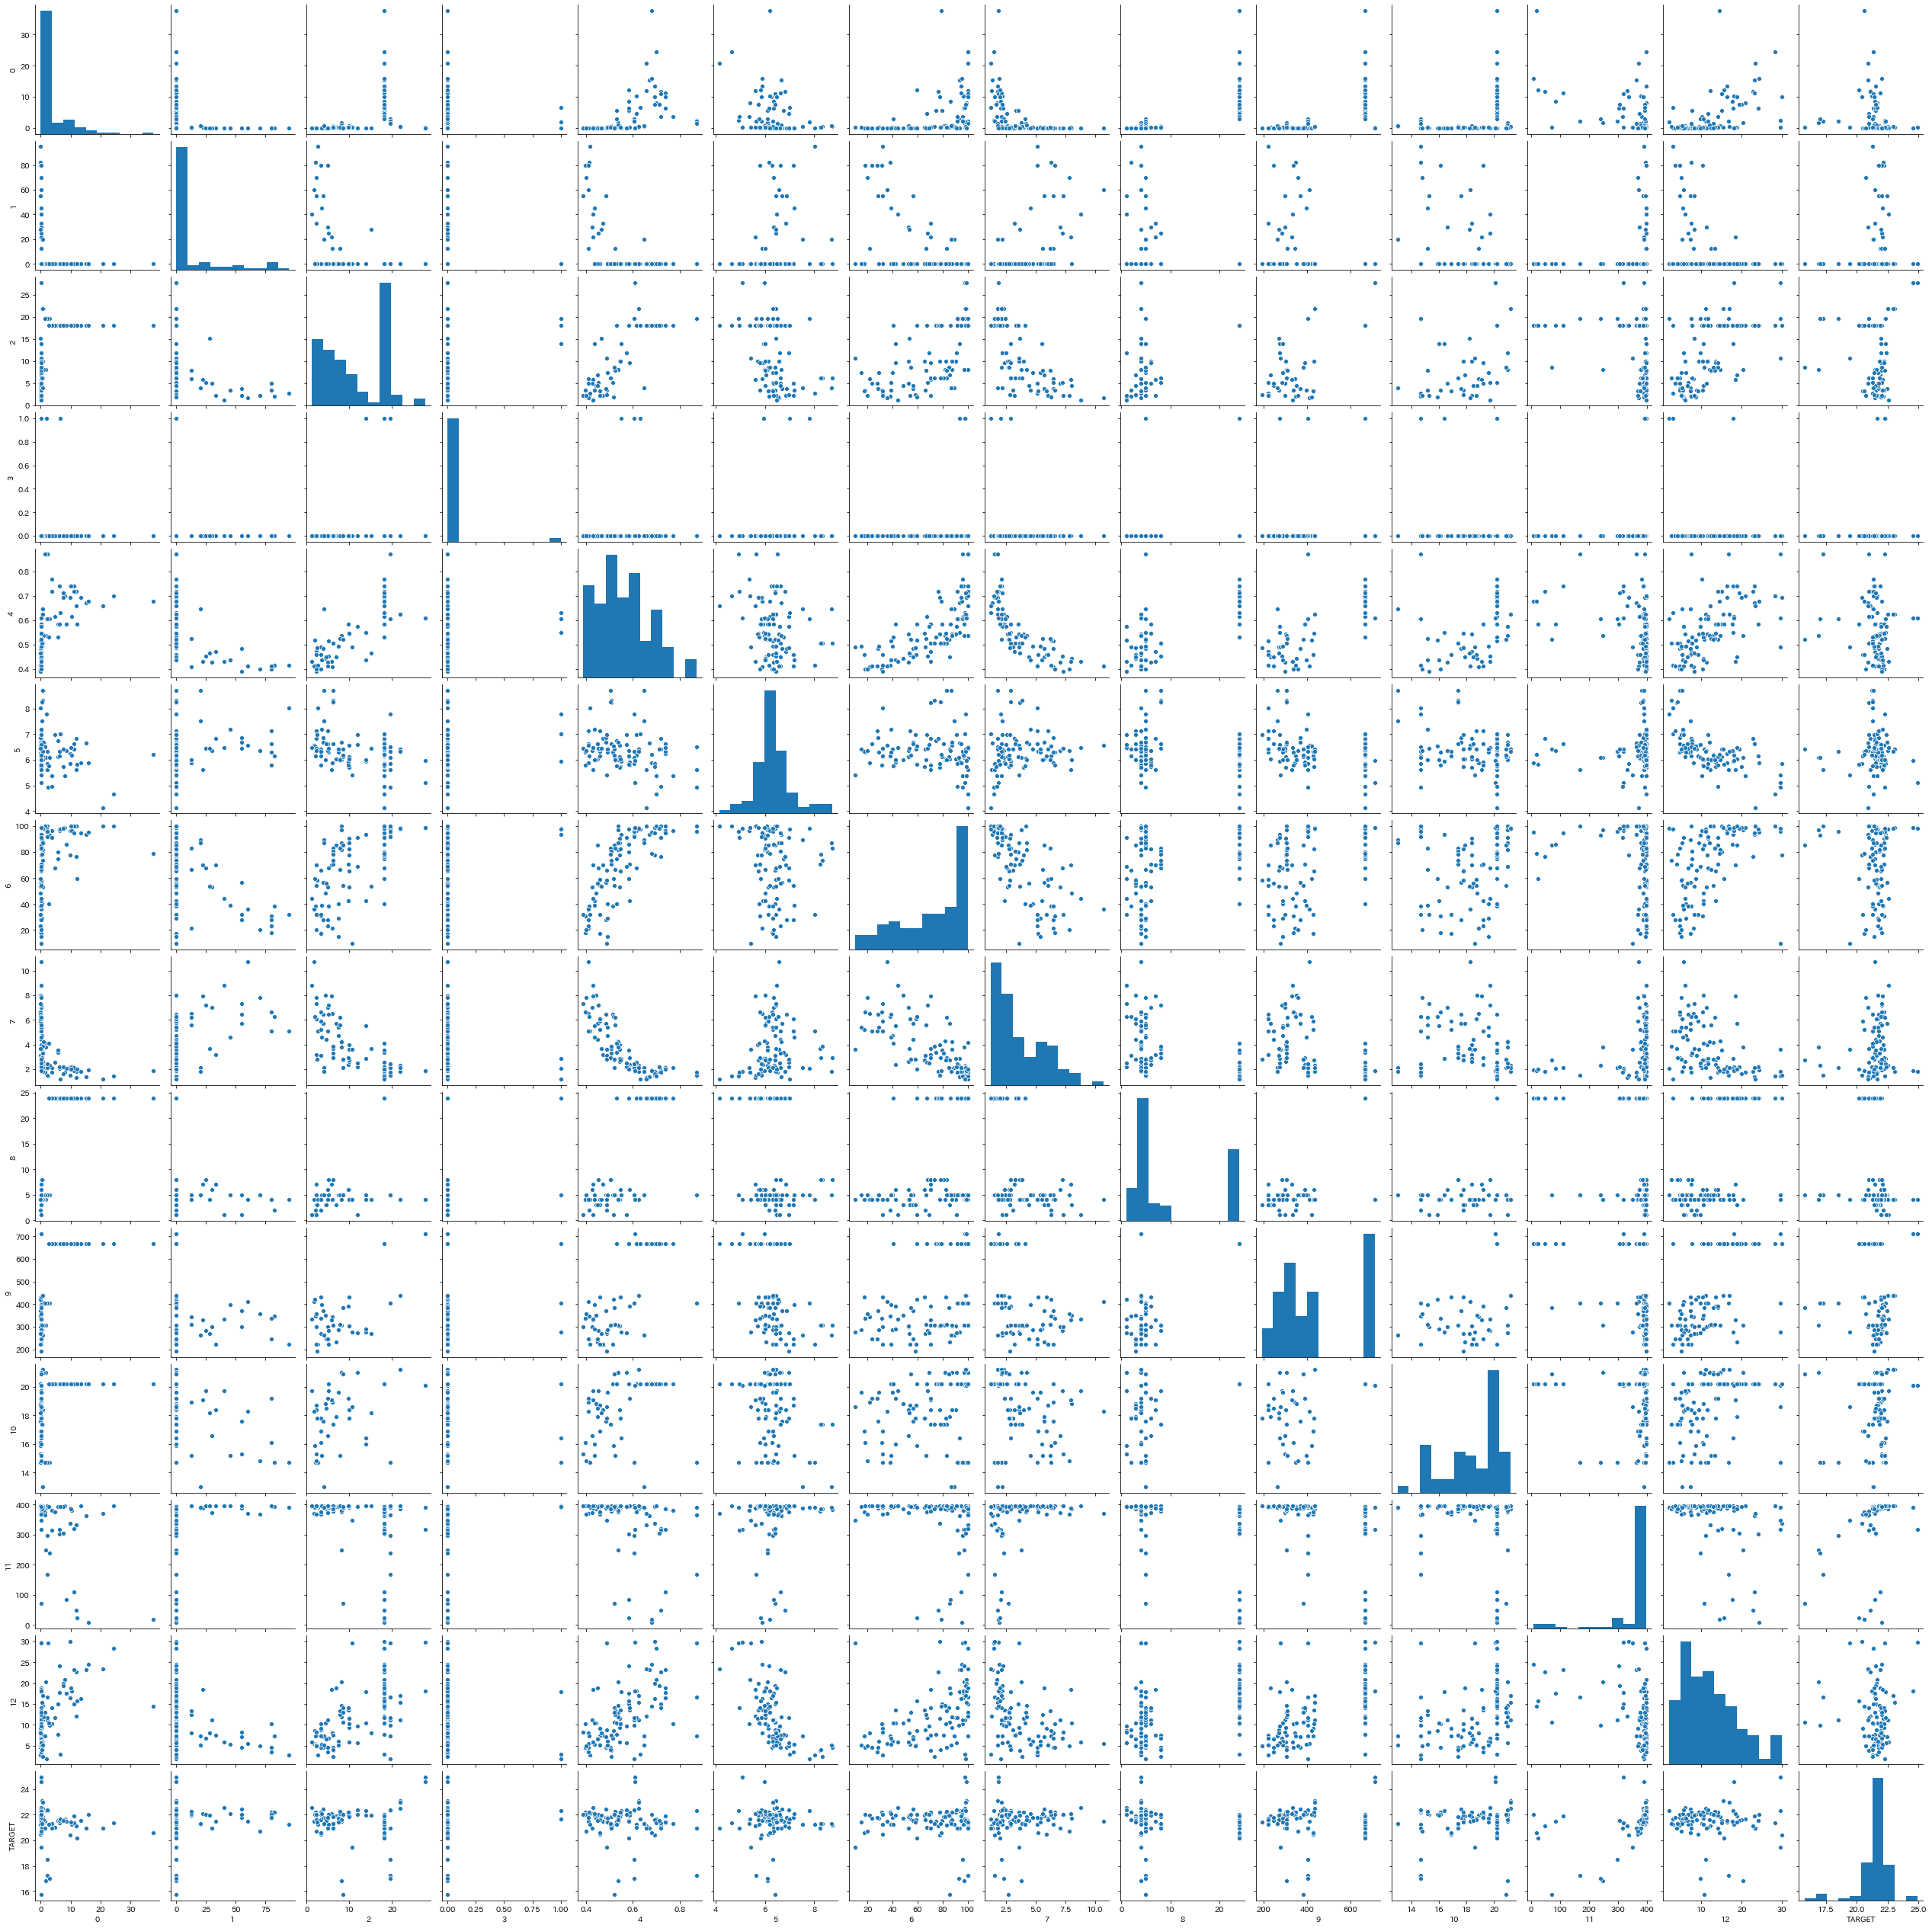

In [54]:
plot=pd.DataFrame(x_test.detach().numpy().copy() )
plot['TARGET']=y_hat.detach().numpy().copy() 
sns.pairplot(plot)

In [55]:
plot.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,TARGET
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,3.281089,10.715686,11.371569,0.029412,0.561305,6.347382,71.106865,3.671989,9.862745,427.960785,18.522547,354.774170,12.156077,21.472490
std,5.997486,23.561539,6.936416,0.169792,0.112075,0.753613,26.426094,2.049614,8.849724,165.919876,2.156267,90.734070,6.846249,1.239630
min,0.010960,0.000000,1.250000,0.000000,0.389000,4.138000,9.800000,1.178100,1.000000,193.000000,13.000000,7.680000,1.920000,15.778154
25%,0.079020,0.000000,4.995000,0.000000,0.484000,5.984750,53.075001,2.079000,4.000000,304.000000,17.400000,371.272499,6.735000,21.274898
50%,0.320380,0.000000,9.900000,0.000000,0.541000,6.326000,78.500000,2.891000,5.000000,384.000000,19.200001,390.329987,10.865000,21.610125
75%,3.692267,0.000000,18.100000,0.000000,0.624000,6.611750,95.624998,5.190450,24.000000,666.000000,20.200001,396.390007,16.417500,22.017261
max,37.661900,95.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,21.200001,396.899994,29.969999,24.921370
